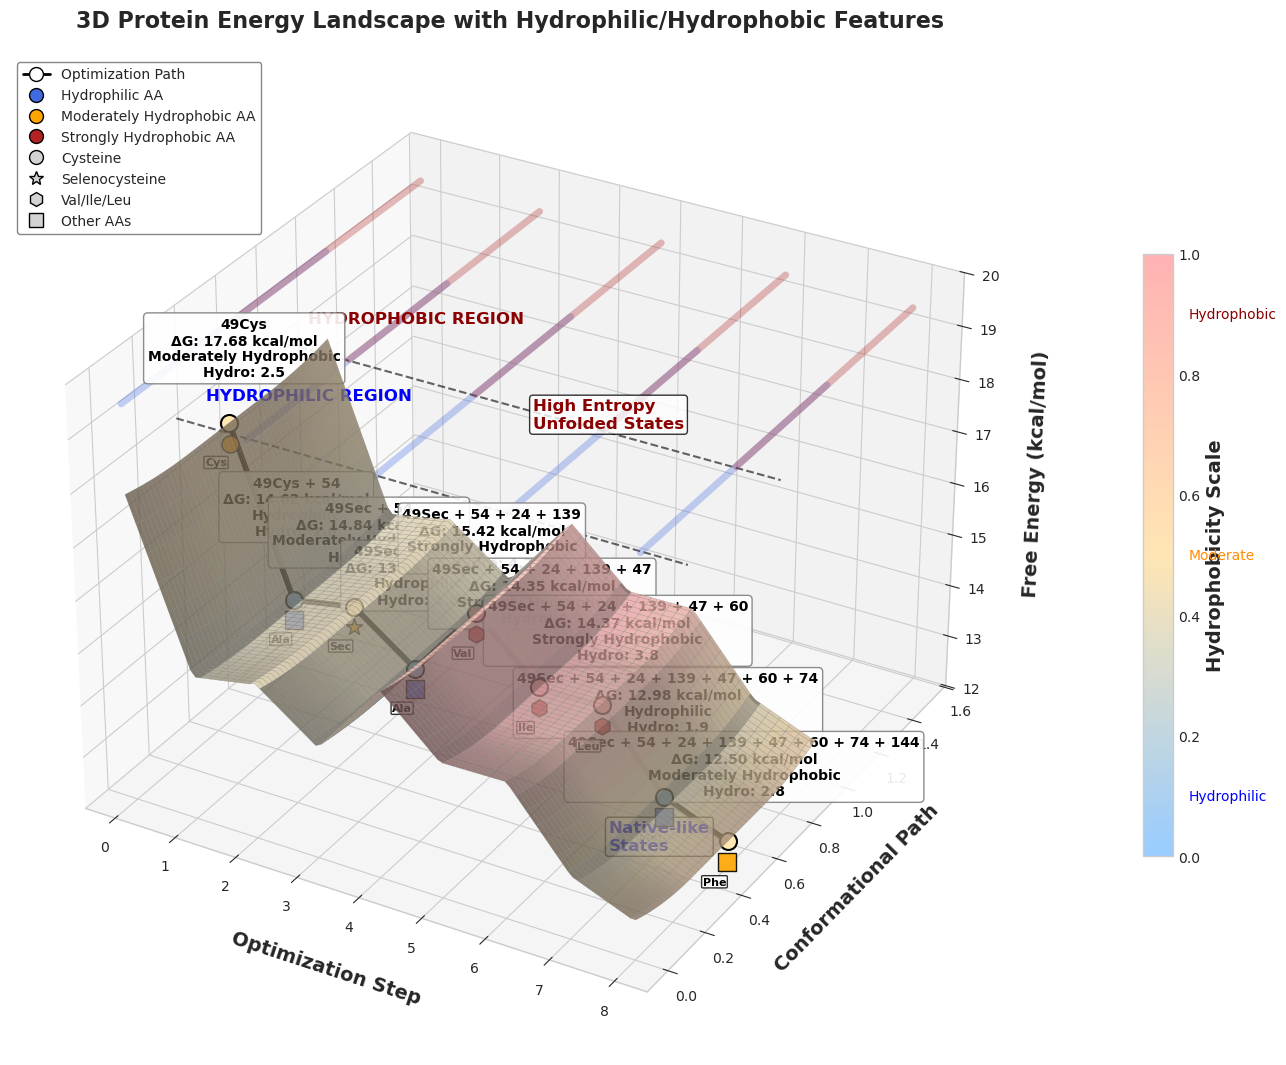

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data - keep original barriers
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74 + 144"
]

# Add amino acid features - hydrophobicity scales (Kyte-Doolittle)
# Higher values = more hydrophobic
hydrophobicity = {
    'Cys': 2.5,  # Cysteine
    'Sec': 2.0,  # Selenocysteine (estimated)
    'Ala': 1.8,  # Positions 24, 54, etc. (Using representative values)
    'Val': 4.2,  # Position 139
    'Ile': 4.5,  # Position 47
    'Leu': 3.8,  # Position 60
    'Met': 1.9,  # Position 74
    'Phe': 2.8   # Position 144
}

# Map each mutation to the last amino acid changed
mutation_aa = {
    0: 'Cys',
    1: 'Ala',  # Position 54
    2: 'Sec',  # Now 49Sec
    3: 'Ala',  # Position 24
    4: 'Val',  # Position 139
    5: 'Ile',  # Position 47
    6: 'Leu',  # Position 60
    7: 'Met',  # Position 74
    8: 'Phe'   # Position 144
}

# Extract hydrophobicity for each mutation step
mutation_hydrophobicity = [hydrophobicity[mutation_aa[i]] for i in range(len(levels))]

# Define hydrophilic/hydrophobic classification
def classify_aa(h_value):
    if h_value < 2.0:
        return "Hydrophilic"
    elif h_value < 3.0:
        return "Moderately Hydrophobic"
    else:
        return "Strongly Hydrophobic"

# Get classification for each AA
mutation_class = [classify_aa(h) for h in mutation_hydrophobicity]

# Amino acid volumes (approximate in Å³)
aa_volume = {
    'Cys': 108.5,
    'Sec': 116.0,  # Estimated
    'Ala': 88.6,
    'Val': 140.0,
    'Ile': 166.7,
    'Leu': 166.7,
    'Met': 162.9,
    'Phe': 189.9
}

# Extract volumes for each mutation step
mutation_volume = [aa_volume[mutation_aa[i]] for i in range(len(levels))]

# Use lighter color scheme - based on hydrophobicity
def hydrophobicity_color(h_value):
    # Light blue (hydrophilic) to light red (hydrophobic)
    # Normalize to 0-1 range
    min_h = min(hydrophobicity.values())
    max_h = max(hydrophobicity.values())
    norm_h = (h_value - min_h) / (max_h - min_h)
    
    # Use lighter colors (pastel shades)
    if h_value < 2.0:  # Hydrophilic
        return (0.6, 0.8, 1.0)  # Light blue
    elif h_value < 3.0:  # Moderately hydrophobic
        return (1.0, 0.9, 0.7)  # Light yellow/orange
    else:  # Strongly hydrophobic
        return (1.0, 0.7, 0.7)  # Light red

colors_custom = [hydrophobicity_color(h) for h in mutation_hydrophobicity]

# Create figure
fig = plt.figure(figsize=(14, 11))

# Create 3D surface plot
ax = plt.axes(projection='3d')

# Create smooth surface function for 3D plot with enhanced features
def create_smooth_surface(levels, barriers, hydrophobicity_values, volume_values):
    x = np.linspace(0, len(levels)-1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    hydro_surface = np.zeros_like(X)
    
    for i in range(len(X)):
        for j in range(len(X[0])):
            xval = X[i][j]
            if xval <= levels[0]:
                Z[i][j] = barriers[0]
                hydro_surface[i][j] = hydrophobicity_values[0]
            elif xval >= levels[-1]:
                Z[i][j] = barriers[-1]
                hydro_surface[i][j] = hydrophobicity_values[-1]
            else:
                idx = np.searchsorted(levels, xval)
                t = (xval - levels[idx-1]) / (levels[idx] - levels[idx-1])
                Z[i][j] = barriers[idx-1] + t * (barriers[idx] - barriers[idx-1])
                hydro_surface[i][j] = hydrophobicity_values[idx-1] + t * (hydrophobicity_values[idx] - hydrophobicity_values[idx-1])
            
            # Create funnel shape
            center_y = 0.5
            dist_from_center = abs(Y[i][j] - center_y)
            
            # Make a deeper valley along the center path
            if dist_from_center < 0.2:
                variance = 0
            else:
                # Add amino acid volume influence to the landscape
                vol_idx = min(int(xval), len(volume_values)-1)
                if vol_idx < 0:
                    vol_idx = 0
                volume_factor = volume_values[vol_idx] / max(volume_values)
                variance = 3 * (dist_from_center - 0.2)**2 * volume_factor
                
            Z[i][j] += variance
            
    return X, Y, Z, hydro_surface

X_smooth, Y_smooth, Z_smooth, hydro_surface = create_smooth_surface(
    levels, barriers, mutation_hydrophobicity, mutation_volume)

# Create custom colormap for hydrophobicity with lighter colors
hydro_cmap = LinearSegmentedColormap.from_list(
    'hydrophobicity', 
    [(0, (0.6, 0.8, 1.0)),      # Light blue (hydrophilic)
     (0.5, (1.0, 0.9, 0.7)),    # Light yellow/orange (moderate)
     (1, (1.0, 0.7, 0.7))],     # Light red (hydrophobic)
    N=100
)

# Plot the smooth surface colored by hydrophobicity
surf = ax.plot_surface(X_smooth, Y_smooth, Z_smooth, 
                     facecolors=hydro_cmap(hydro_surface/max(mutation_hydrophobicity)),
                     alpha=0.8, 
                     edgecolor='gray',
                     rstride=2, cstride=2,
                     linewidth=0.2, 
                     antialiased=True,
                     shade=True)

# Plot a highlighted path on the surface
path_y = np.ones(len(levels)) * 0.5
ax.plot(levels, path_y, barriers, color='black', linewidth=4, 
       marker='o', markersize=10, markerfacecolor='white', markeredgecolor='black', 
       label="Optimization Path")

# Add hydrophilic/hydrophobic regions annotation
ax.plot([0, 8], [0.25, 0.25], [18.5, 18.5], 'k--', alpha=0.6)
ax.text(0.5, 0.25, 19.0, "HYDROPHILIC REGION", fontsize=12, color='blue', fontweight='bold')
ax.plot([0, 8], [0.75, 0.75], [18.5, 18.5], 'k--', alpha=0.6)
ax.text(0.5, 0.75, 19.0, "HYDROPHOBIC REGION", fontsize=12, color='darkred', fontweight='bold')

# Add points for each mutation
for i in range(len(levels)):
    # Lighter, more visible markers
    ax.scatter(levels[i], 0.5, barriers[i], color=colors_custom[i], s=150, 
              edgecolor='black', linewidth=1.5, zorder=100)
    
    # Position text labels with clear background
    z_offset = 0.7 if i % 2 == 0 else 1.0
    x_offset = 0.1 if i % 2 == 0 else -0.1
    
    # Add level number, mutation, free energy and hydrophobicity/class to each point
    level_label = f"{mutations[i]}\nΔG: {barriers[i]:.2f} kcal/mol\n{mutation_class[i]}\nHydro: {mutation_hydrophobicity[i]:.1f}"
    ax.text(levels[i] + x_offset, 0.55, barriers[i] + z_offset, 
           level_label,
           color='black', fontsize=10, ha='center', va='bottom', fontweight='bold',
           bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3', edgecolor='gray'))

# Add amino acid symbols with clearer labels
def add_aa_symbol(ax, x, y, z, aa_type, hydro_value):
    # Color based on hydrophobicity
    if hydro_value < 2.0:  # Hydrophilic
        color = 'royalblue'
        label = "Hydrophilic"
    elif hydro_value < 3.0:  # Moderately hydrophobic
        color = 'orange' 
        label = "Moderate"
    else:  # Strongly hydrophobic
        color = 'firebrick'
        label = "Hydrophobic"
        
    # Different marker shapes for different amino acid types
    if aa_type == 'Cys':
        marker = 'o'
    elif aa_type == 'Sec':
        marker = '*'
    elif aa_type in ['Val', 'Ile', 'Leu']:
        marker = 'h'
    else:
        marker = 's'
        
    ax.scatter(x, y, z, color=color, s=150, marker=marker, 
              edgecolor='black', linewidth=1, alpha=0.9, zorder=100)
    
    # Add small label
    ax.text(x, y-0.07, z-0.2, aa_type, 
           color='black', fontsize=8, ha='center', fontweight='bold',
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.1'))

# Add amino acid representations along the path
for i in range(len(levels)):
    add_aa_symbol(ax, levels[i], 0.5, barriers[i] - 0.4, 
                 mutation_aa[i], mutation_hydrophobicity[i])

# Add a colorbar for hydrophobicity with improved labels
cbar = fig.colorbar(cm.ScalarMappable(cmap=hydro_cmap), ax=ax, shrink=0.6, aspect=20, pad=0.1)
cbar.set_label('Hydrophobicity Scale', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=10)

# Add text annotations for hydrophobicity scale
cbar.ax.text(1.5, 0.1, "Hydrophilic", fontsize=10, ha='left', va='center', color='blue')
cbar.ax.text(1.5, 0.5, "Moderate", fontsize=10, ha='left', va='center', color='darkorange')
cbar.ax.text(1.5, 0.9, "Hydrophobic", fontsize=10, ha='left', va='center', color='darkred')

# Add text for the energy landscape with clear backgrounds
ax.text(4, 0.8, 18, "High Entropy\nUnfolded States", fontsize=12, color='darkred', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
ax.text(7, 0.2, 13, "Native-like\nStates", fontsize=12, color='blue', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

# Add hydrophilic/hydrophobic feature bands
y_coords = np.linspace(0, 1, 100)
for x_val in [0, 2, 4, 6, 8]:
    z_high = np.ones_like(y_coords) * 19.5
    # Color bands showing hydrophilic (blue) to hydrophobic (red) transitions
    ax.plot([x_val]*len(y_coords), y_coords, z_high, 
           color='royalblue', linewidth=5, alpha=0.3)
    ax.plot([x_val]*len(y_coords), y_coords + 0.5, z_high, 
           color='firebrick', linewidth=5, alpha=0.3)

# Add axes labels and title with better contrast
ax.set_xlabel("Optimization Step", fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel("Conformational Path", fontsize=14, fontweight='bold', labelpad=15)
ax.set_zlabel("Free Energy (kcal/mol)", fontsize=14, fontweight='bold', labelpad=15)
ax.set_title("3D Protein Energy Landscape with Hydrophilic/Hydrophobic Features", 
           fontsize=16, fontweight='bold', pad=20)

# Adjust view angle for better visibility
ax.view_init(elev=30, azim=-60)
ax.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xlim(-0.5, len(levels)-0.5)
ax.set_zlim(12, 20)

# Add legend with clearer labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='o', linestyle='-', 
               markerfacecolor='white', markeredgecolor='black',
               markersize=10, linewidth=2, label="Optimization Path"),
    plt.Line2D([0], [0], marker='o', color='royalblue', markeredgecolor='black',
               markersize=10, linewidth=0, label="Hydrophilic AA"),
    plt.Line2D([0], [0], marker='o', color='orange', markeredgecolor='black',
               markersize=10, linewidth=0, label="Moderately Hydrophobic AA"),
    plt.Line2D([0], [0], marker='o', color='firebrick', markeredgecolor='black',
               markersize=10, linewidth=0, label="Strongly Hydrophobic AA"),
    plt.Line2D([0], [0], marker='o', color='lightgray', markeredgecolor='black',
               markersize=10, linewidth=0, label="Cysteine"),
    plt.Line2D([0], [0], marker='*', color='lightgray', markeredgecolor='black',
               markersize=10, linewidth=0, label="Selenocysteine"),
    plt.Line2D([0], [0], marker='h', color='lightgray', markeredgecolor='black',
               markersize=10, linewidth=0, label="Val/Ile/Leu"),
    plt.Line2D([0], [0], marker='s', color='lightgray', markeredgecolor='black',
               markersize=10, linewidth=0, label="Other AAs")
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
         frameon=True, framealpha=0.95, edgecolor='gray')

plt.tight_layout(pad=2.0)
plt.show()

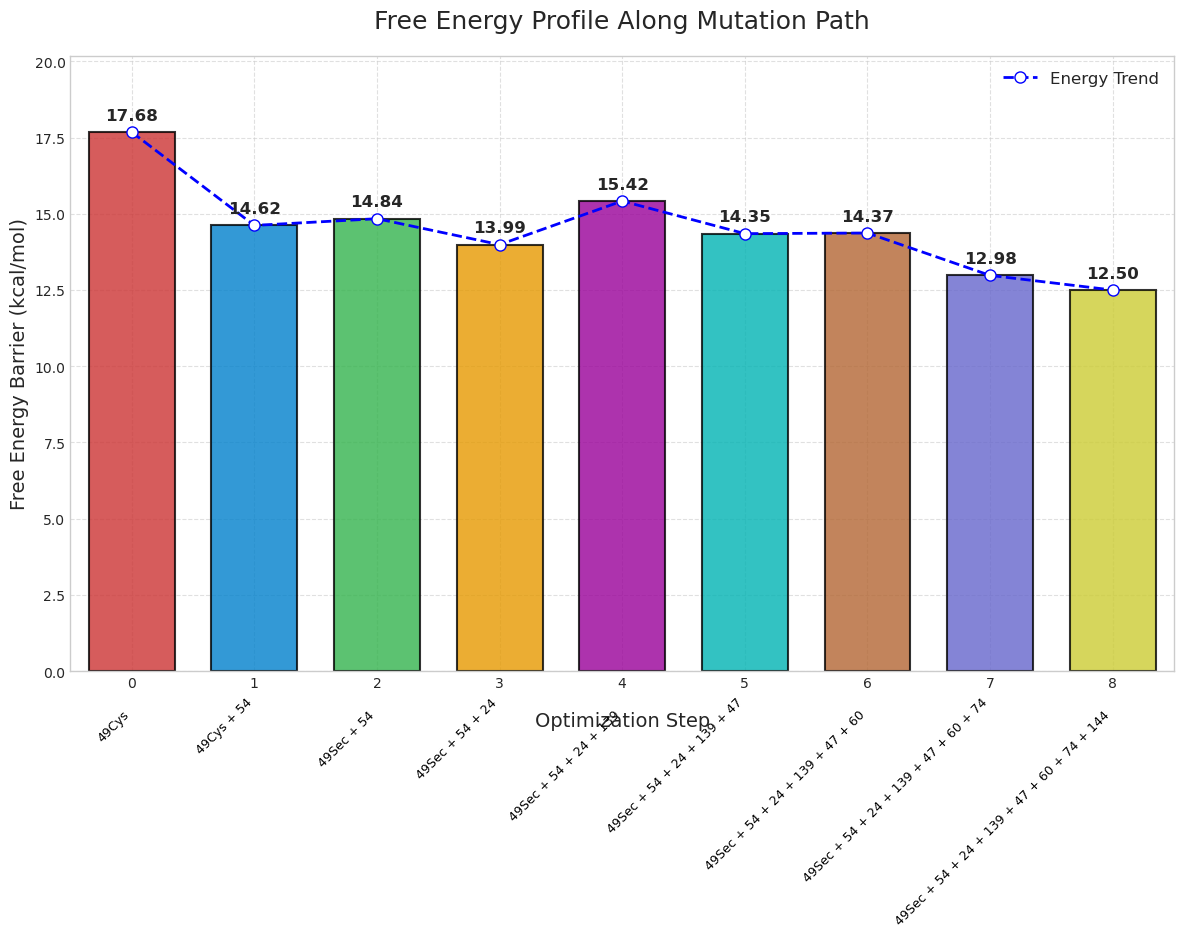

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74 + 144"
]

# Define a custom colormap with distinct colors
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8),  # Lavender for level 7
    (0.8, 0.8, 0.2)   # Yellow for level 8
]

# Create figure
plt.figure(figsize=(12, 8))

# Create bars with custom colors
for i, (lvl, val) in enumerate(zip(levels, barriers)):
    plt.bar(lvl, val, width=0.7, color=colors_custom[i], 
            edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels
    plt.text(lvl, val + 0.3, f"{val:.2f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add mutation labels underneath with rotation
for i, mutation in enumerate(mutations):
    if i % 2 == 0:  # Alternate label positioning for readability
        plt.text(i, -1.2, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')
    else:
        plt.text(i, -0.8, mutation, ha='right', va='top', rotation=45, 
                fontsize=9, color='black')

# Add trend line
plt.plot(levels, barriers, 'o--', color='blue', markersize=8, 
         linewidth=2, markerfacecolor='white', markeredgecolor='blue',
         label="Energy Trend")

plt.title("Free Energy Profile Along Mutation Path", fontsize=18, pad=20)
plt.xlabel("Optimization Step", fontsize=14, labelpad=15)
plt.ylabel("Free Energy Barrier (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(levels, [f"{i}" for i in range(len(levels))])
plt.xlim(-0.5, max(levels) + 0.5)
plt.ylim(0, max(barriers) + 2.5)  # Extra space for labels and annotations

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add annotation explaining the trend
#plt.annotate('Progressive optimization \ntowards native state', 
          #  xy=(7, 13.5), xytext=(5, 16),
          #  arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
          #  fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for mutation labels
plt.show()

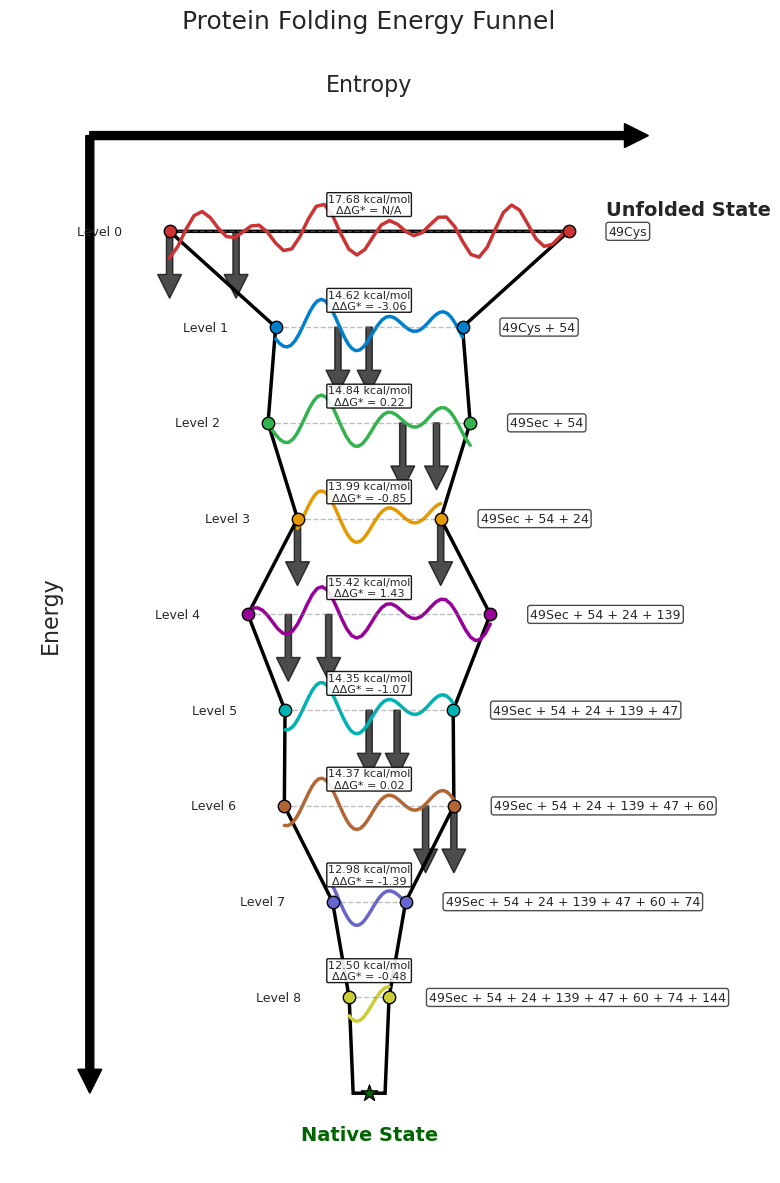

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74 + 144"
]

# Calculate ΔΔG* values (difference from preceding level)
ddg_values = [0]  # First level has no preceding level
for i in range(1, len(barriers)):
    ddg = barriers[i] - barriers[i-1]
    ddg_values.append(ddg)

# Color scheme
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8),  # Lavender for level 7
    (0.8, 0.8, 0.2)   # Yellow for level 8
]

# Create figure
plt.figure(figsize=(10, 12))
ax = plt.gca()

# Normalize energy values for consistent display
energy_min = min(barriers)
energy_max = max(barriers)
normalized_energy = [(energy_max - e + energy_min)/energy_max * 10 for e in barriers]

# Create funnel shape
# Adjust these parameters to change the funnel shape
funnel_top = 5  # Width at the top
funnel_bottom = 0.5  # Width at the bottom
funnel_height = 12  # Total height
spacing = funnel_height / (len(levels) + 1)  # Space between levels

# Calculate y-positions for each level (top to bottom)
y_positions = [funnel_height - (i+1) * spacing for i in range(len(levels))]
y_positions.append(0)  # Add bottom position for native state

# Calculate widths for each level
max_width = funnel_top
min_width = funnel_bottom
widths = []

for i, barrier in enumerate(barriers):
    # Convert energy to width (higher energy = wider funnel)
    width_factor = (barrier - energy_min) / (energy_max - energy_min)
    width = min_width + width_factor * (max_width - min_width)
    widths.append(width)

# Add native state at the bottom (narrowest point)
widths.append(min_width * 0.8)

# Draw funnel outline
x_points = []
y_points = []

# Right side (top to bottom)
for i in range(len(widths)):
    x_points.append(widths[i]/2)
    y_points.append(y_positions[i])

# Left side (bottom to top) - add points in reverse
for i in range(len(widths)-1, -1, -1):
    x_points.append(-widths[i]/2)
    y_points.append(y_positions[i])

# Close the path
x_points.append(widths[0]/2)
y_points.append(y_positions[0])

# Create a path for the funnel outline
funnel_path = Path(list(zip(x_points, y_points)))
funnel_patch = patches.PathPatch(funnel_path, facecolor='none', edgecolor='black', linewidth=2.5)
ax.add_patch(funnel_patch)

# Create the level contours (horizontal lines with bumps)
for i in range(len(levels)):
    # Energy contour coordinates
    y = y_positions[i]
    width = widths[i]
    
    # Basic horizontal line
    x_left = -width/2
    x_right = width/2
    
    # Create points for a bumpy line representing energy landscape
    x_bumps = np.linspace(x_left, x_right, 50)
    y_bumps = y + np.sin(x_bumps * 8) * 0.2 - np.cos(x_bumps * 5) * 0.15  # Add waves
    
    # Plot the bumpy energy landscape level
    plt.plot(x_bumps, y_bumps, '-', color=colors_custom[i], linewidth=2.5)
    
    # Add a horizontal marker line
    plt.plot([x_left, x_right], [y, y], '--', color='gray', alpha=0.5, linewidth=1)

    # Add level markers on both sides
    # Left side
    plt.scatter(x_left, y, s=80, color=colors_custom[i], edgecolor='black', zorder=5)
    plt.text(x_left - 0.6, y, f"Level {i}", fontsize=9, ha='right', va='center')
    
    # Right side - mutation info
    plt.scatter(x_right, y, s=80, color=colors_custom[i], edgecolor='black', zorder=5)
    plt.text(x_right + 0.5, y, mutations[i], fontsize=9, ha='left', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
    
    # Energy value and ΔΔG* information
    ddg_text = f"ΔΔG* = {ddg_values[i]:.2f}" if i > 0 else "ΔΔG* = N/A"
    energy_text = f"{barriers[i]:.2f} kcal/mol\n{ddg_text}"
    plt.text(0, y + 0.2, energy_text, fontsize=8, ha='center', va='bottom',
            bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.1'))

# Add native state at the bottom
bottom_y = y_positions[-1]
plt.scatter(0, bottom_y, s=150, color='darkgreen', marker='*', edgecolor='black', zorder=5)
plt.text(0, bottom_y - 0.4, "Native State", fontsize=14, fontweight='bold', 
        ha='center', va='top', color='darkgreen')

# Add arrows showing direction toward native state
arrow_count = 14
for i in range(arrow_count):
    # Determine arrow starting point
    level = int(i / 2)  # Distribute across levels
    if level >= len(y_positions) - 1:
        level = len(y_positions) - 2
    
    y_start = y_positions[level] 
    x_fraction = (i % 7) / 6  # Distribute horizontally
    
    # Calculate width at this level
    if level < len(widths):
        width = widths[level]
    else:
        width = widths[-1]
    
    x_start = -width/2 + width * x_fraction
    
    # Calculate arrow angle (point down and slightly inward)
    angle = -90  # Down
    if x_start < 0:
        angle -= 15  # Down and right
    elif x_start > 0:
        angle -= -15  # Down and left
    
    # Draw the arrow
    plt.arrow(x_start, y_start, 0, -spacing*0.7, width=0.08, 
              head_width=0.3, head_length=0.3, 
              fc='black', ec='black', alpha=0.7,
              length_includes_head=True)

# Add entropy and energy axis labels
plt.text(0, funnel_height + 0.5, "Entropy", fontsize=16, ha='center', va='bottom')
plt.arrow(-funnel_top/2 - 1, funnel_height, funnel_top + 2, 0, width=0.1, 
         head_width=0.3, head_length=0.3, fc='black', ec='black', 
         length_includes_head=True)

plt.text(-funnel_top/2 - 1.5, funnel_height/2, "Energy", fontsize=16, rotation=90, va='center', ha='center')
plt.arrow(-funnel_top/2 - 1, funnel_height, 0, -funnel_height, width=0.1, 
         head_width=0.3, head_length=0.3, fc='black', ec='black',
         length_includes_head=True)

# Add top state label (only keep unfolded state)
plt.text(4, funnel_height - 1, "Unfolded State", fontsize=14, fontweight='bold', ha='center')

# Set up axes
ax.set_xlim(-funnel_top/2 - 2, funnel_top/2 + 2)
ax.set_ylim(-1, funnel_height + 1)
ax.set_aspect('equal')
ax.axis('off')  # Hide the axes
plt.title("Protein Folding Energy Funnel", fontsize=18, pad=20)

plt.tight_layout()
plt.savefig('protein_energy_funnel_with_ddg.png', dpi=300, bbox_inches='tight')
plt.show()

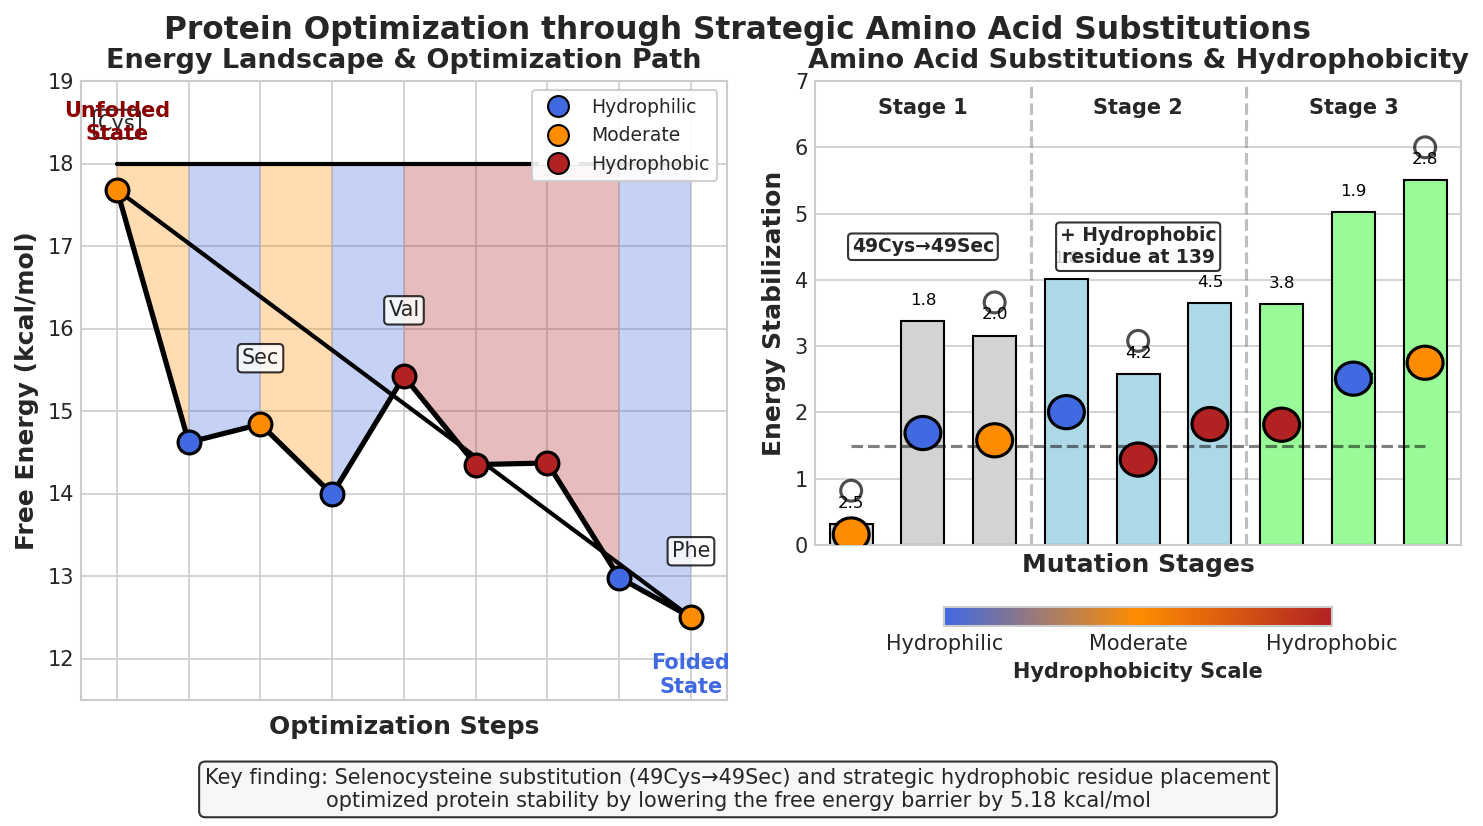

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle
from matplotlib.path import Path
import matplotlib.patches as patches

# Create a clean figure with two panels
fig = plt.figure(figsize=(10, 5.5), dpi=150)
plt.subplots_adjust(wspace=0.1)

# Define data from the original visualization
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 12.50])
mutations = ["49Cys", "49Cys\n+54", "49Sec\n+54", "49Sec\n+54+24", "49Sec\n+54+24\n+139", 
            "49Sec\n+54+24\n+139+47", "49Sec\n+54+24\n+139+47\n+60", 
            "49Sec\n+54+24\n+139+47\n+60+74", "49Sec\n+54+24\n+139+47\n+60+74\n+144"]

# Add amino acid properties
hydrophobicity = {
    'Cys': 2.5,  
    'Sec': 2.0,  
    'Ala': 1.8,  
    'Val': 4.2,  
    'Ile': 4.5,  
    'Leu': 3.8,  
    'Met': 1.9,  
    'Phe': 2.8   
}

mutation_aa = {
    0: 'Cys', 1: 'Ala', 2: 'Sec', 3: 'Ala', 4: 'Val',
    5: 'Ile', 6: 'Leu', 7: 'Met', 8: 'Phe'
}

# Extract hydrophobicity for each mutation step
mutation_hydrophobicity = [hydrophobicity[mutation_aa[i]] for i in range(len(levels))]

# Define hydrophilic/hydrophobic classification
def classify_aa(h_value):
    if h_value < 2.0:
        return "Hydrophilic"
    elif h_value < 3.0:
        return "Moderate"
    else:
        return "Hydrophobic"

# Get classification for each AA
mutation_class = [classify_aa(h) for h in mutation_hydrophobicity]

# Color mapping function
def hydro_color(h_value):
    if h_value < 2.0:  # Hydrophilic
        return 'royalblue'
    elif h_value < 3.0:  # Moderately hydrophobic
        return 'darkorange' 
    else:  # Strongly hydrophobic
        return 'firebrick'

colors = [hydro_color(h) for h in mutation_hydrophobicity]

# Create diagonal lines to divide the plot
def draw_diagonal(ax, x_min, x_max, y_min, y_max, **kwargs):
    ax.plot([x_min, x_max], [y_min, y_max], **kwargs)

# ============= LEFT PANEL: Stylized Energy Funnel =============
ax1 = plt.subplot(121)

# Create funnel shape
funnel_x = [0, 8, 8, 0]
funnel_y = [18, 12, 18, 18]

# Draw funnel with gradient fill
for i in range(len(levels)-1):
    # Create gradient polygons
    x_points = [levels[i], levels[i+1], levels[i+1], levels[i]]
    y_points = [barriers[i], barriers[i+1], 18, 18]
    
    # Fill with color based on hydrophobicity
    poly = plt.Polygon(np.column_stack([x_points, y_points]), 
                      facecolor=colors[i], alpha=0.3)
    ax1.add_patch(poly)

# Draw outline of funnel
ax1.plot([0, 8], [18, 18], 'k-', lw=2)
ax1.plot([0, 8], [barriers[0], barriers[-1]], 'k-', lw=2)

# Add the optimization path points
ax1.plot(levels, barriers, 'k-', lw=2.5)
for i in range(len(levels)):
    ax1.scatter(levels[i], barriers[i], s=120, color=colors[i], 
               edgecolor='black', zorder=10, linewidth=1.5)

# Add small labels for key mutations
for i in [0, 2, 4, 8]:  # Only label selected points
    if i == 0:
        ax1.annotate(f"{mutation_aa[i]}", (levels[i], barriers[i]+0.8),
                   fontsize=10, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    elif i == 8:
        ax1.annotate(f"{mutation_aa[i]}", (levels[i], barriers[i]+0.8),
                   fontsize=10, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))
    else:
        ax1.annotate(f"{mutation_aa[i]}", (levels[i], barriers[i]+0.8),
                   fontsize=10, ha='center', va='center',
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

# Add legend for hydrophobicity
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='royalblue',
              markeredgecolor='black', markersize=10, label='Hydrophilic'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkorange',
              markeredgecolor='black', markersize=10, label='Moderate'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='firebrick',
              markeredgecolor='black', markersize=10, label='Hydrophobic')
]
ax1.legend(handles=legend_elements, loc='upper right', frameon=True, 
          framealpha=0.9, fontsize=9)

# Add labels and title
ax1.set_xlabel('Optimization Steps', fontsize=12, fontweight='bold')
ax1.set_ylabel('Free Energy (kcal/mol)', fontsize=12, fontweight='bold')
ax1.set_title('Energy Landscape & Optimization Path', fontsize=13, fontweight='bold')
ax1.set_xlim(-0.5, 8.5)
ax1.set_ylim(11.5, 19)
ax1.set_xticks(levels)
ax1.set_xticklabels([])

# Add annotations for start and end points
ax1.annotate("Unfolded\nState", (0, 18.5), fontsize=10, ha='center', va='center',
           fontweight='bold', color='darkred')
ax1.annotate("Folded\nState", (8, 11.8), fontsize=10, ha='center', va='center',
           fontweight='bold', color='royalblue')

# ============= RIGHT PANEL: Amino Acid Changes & Hydrophobicity =============
ax2 = plt.subplot(122)

# Create bars showing energy decrease
width = 0.6
bar_heights = 18 - barriers
bar_colors = ['lightgray' if x < 3 else 'lightblue' if x < 6 else 'palegreen' for x in range(len(levels))]

# Add bars with mutation labels
bars = ax2.bar(levels, bar_heights, width=width, color=bar_colors, 
              edgecolor='black', linewidth=1)

# Add amino acid information
for i, (x, height) in enumerate(zip(levels, bar_heights)):
    # Add amino acid type
    symbol_y = height/2
    
    # Add amino acid circle with color based on hydrophobicity
    circle = Circle((x, symbol_y), 0.25, 
                   facecolor=colors[i], 
                   edgecolor='black', 
                   linewidth=1.5,
                   zorder=10)
    ax2.add_patch(circle)
    
    # Add amino acid label
    ax2.text(x, symbol_y, mutation_aa[i], 
            ha='center', va='center', 
            fontsize=9, fontweight='bold', 
            color='black')
    
    # Add hydrophobicity value at the top
    ax2.text(x, height + 0.2, f"{mutation_hydrophobicity[i]:.1f}", 
            ha='center', va='bottom', 
            fontsize=8, color='black')

# Add a dashed line connecting the key amino acids
ax2.plot(levels, [1.5]*len(levels), 'k--', alpha=0.5)

# Highlight the critical mutations
critical_positions = [0, 2, 4, 8]
for pos in critical_positions:
    ax2.scatter(levels[pos], bar_heights[pos] + 0.5, s=100, 
               facecolor='none', edgecolor='black', linewidth=1.5, alpha=0.7)

# Add explanatory text for key mutations
ax2.annotate("49Cys→49Sec", (1.0, 4.5), fontsize=9, fontweight='bold',
           ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

ax2.annotate("+ Hydrophobic\nresidue at 139", (4.0, 4.5), fontsize=9, fontweight='bold',
           ha='center', va='center',
           bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.2'))

# Add labels for the stages of optimization
ax2.annotate("Stage 1", (1, 6.5), fontsize=10, fontweight='bold', ha='center')
ax2.annotate("Stage 2", (4, 6.5), fontsize=10, fontweight='bold', ha='center')
ax2.annotate("Stage 3", (7, 6.5), fontsize=10, fontweight='bold', ha='center')

# Add demarcation lines for stages
ax2.axvline(x=2.5, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=5.5, color='gray', linestyle='--', alpha=0.5)

# Add labels and title
ax2.set_xlabel('Mutation Stages', fontsize=12, fontweight='bold')
ax2.set_ylabel('Energy Stabilization', fontsize=12, fontweight='bold')
ax2.set_title('Amino Acid Substitutions & Hydrophobicity', fontsize=13, fontweight='bold')
ax2.set_xlim(-0.5, 8.5)
ax2.set_ylim(0, 7)
ax2.set_xticks([])

# Add hydrophobicity scale gradient
cmap = LinearSegmentedColormap.from_list('hydrophobicity', 
                                       ['royalblue', 'darkorange', 'firebrick'], 
                                       N=100)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2, orientation='horizontal', shrink=0.6, pad=0.1)
cbar.set_label('Hydrophobicity Scale', fontsize=10, fontweight='bold')
cbar.ax.set_xticks([0, 0.5, 1])
cbar.ax.set_xticklabels(['Hydrophilic', 'Moderate', 'Hydrophobic'])

# Add main title for the whole figure
fig.suptitle('Protein Optimization through Strategic Amino Acid Substitutions', 
            fontsize=15, fontweight='bold', y=0.98)

# Add summary text at bottom
plt.figtext(0.5, 0.02, 
           "Key finding: Selenocysteine substitution (49Cys→49Sec) and strategic hydrophobic residue placement\noptimized protein stability by lowering the free energy barrier by 5.18 kcal/mol", 
           ha='center', fontsize=10, bbox=dict(facecolor='whitesmoke', alpha=0.8, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.show()